# Spam Mail Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PeaceTwinkle/NMKHDL-spam/blob/main/SpamMailClassificationProject_HuynhVanTuAn_207KD40106.ipynb)

## Introduction

Why classifying spam mails is important, at what cost, how will the chosen approach help?

In this project, our team will apply the data science process, tools and techniques to classify [the public data sets of normal and spam mails](https://spamassassin.apache.org/old/publiccorpus/) distributed by Apache [Spam Assassin](https://spamassassin.apache.org/), the top open-source anti-spam platform. 

Our objective is to classify spams based on **content** of English emails, assuming no other languages were used in the text.


## Methodology

### Set up environment
To deal with spam emails in the form of text files, we'll need to use some standard library packages that were installed when we set up Python on our local machine: [os](https://docs.python.org/3.6/library/os.html) and [email](https://docs.python.org/3.6/library/email.html). 

`Email` is a library for ... 

Modules `model_selection`, ... of `scikit-learn`

In [199]:
import os
import email
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score, f1_score
import time
from joblib import parallel_backend


#enable autocomplete by Tab
%config IPCompleter.greedy=True 
# display graphs in jupyter cells
%matplotlib inline 

[nltk_data] Downloading package punkt to C:\Users\An
[nltk_data]     Van\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to C:\Users\An
[nltk_data]     Van\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Store all file names as lists

There are more than 1 data structure suitable for this task, but we chose lists due to the ease of iterating, enumerating through their elements and manipulating them on the fly. Moreover, we only have 2 categories, so dictionary may be an overkill.

In [3]:
path = 'data/'
easy_ham_paths = [path+'easy_ham/'+ file for file in os.listdir(path+'easy_ham/')]
easy_ham_2_paths = [path+'easy_ham_2/'+ file for file in os.listdir(path+'easy_ham_2/')]
hard_ham_paths = [path+'hard_ham/'+ file for file in os.listdir(path+'hard_ham/')]
spam_paths = [path+'spam/'+ file for file in os.listdir(path+'spam/')]
spam_2_paths = [path+'spam_2/'+ file for file in os.listdir(path+'spam_2/')]

Take note that the command `os.listdir(path)` returns a list of all file names in the `path`, but they are not the absolute path required by `os` to open and read a file. Thus, we need to append the directory to each file name. 

A simpler way to save file names with absolute path is to use the [glob](https://docs.python.org/3.6/library/glob.html) standard Python library by calling `glob.glob(path +'/*')`. Since this step is the only time we might need to use this library, we went ahead with the `os` approach. Also, our data set has a relatively small number of files, so using some extra loops is still acceptable.


### Read email content

First, we checked the content of 1 normal email in the easy category

In [6]:
with open(spam_paths[2], mode='r') as file:
    print(file.read())


From sabrina@mx3.1premio.com  Thu Aug 22 14:44:07 2002
Return-Path: <sabrina@mx3.1premio.com>
Delivered-To: zzzz@localhost.spamassassin.taint.org
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 1E90847C66
	for <zzzz@localhost>; Thu, 22 Aug 2002 09:44:02 -0400 (EDT)
Received: from mail.webnote.net [193.120.211.219]
	by localhost with POP3 (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 14:44:03 +0100 (IST)
Received: from email.qves.com (email1.qves.net [209.63.151.251] (may be forged))
	by webnote.net (8.9.3/8.9.3) with ESMTP id OAA04953
	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 14:37:23 +0100
Received: from qvp0086 ([169.254.6.17]) by email.qves.com with Microsoft SMTPSVC(5.0.2195.2966);
	 Thu, 22 Aug 2002 07:36:20 -0600
From: "Slim Down" <sabrina@mx3.1premio.com>
To: <zzzz@spamassassin.taint.org>
Subject: Guaranteed to lose 10-12 lbs in 30 days                          11.150
Date: Thu, 22

There are a lot of details about the sender's and receiver's email addresses such as domains, IP addresses, etc. Most of this information is useful for a cybersecurity specialist, but we are tackling this problem from a data scientist's point of view, so we will first try to look at only the email content according to our predefined objective.

To effectively achieve that goal, we will use `email` package to extract the content of emails. Sometimes, only type `text/plain` is needed, we can set the condition as `if email.get_content_type() == 'text/plain'`, but most modern emails contain html tags, etc., and may not be associated with one exact type. The data structure of most email messages is a tree, each branch of which may belong to a different [content type](https://docs.python.org/3/library/email.message.html#email.message.EmailMessage.walk). 

In [6]:
def flatten(aList):
    t = []
    for i in aList:
        if not isinstance(i, list):
             t.append(i)
        else:
             t.extend(flatten(i))
    return t
flatten([1, [2,3, [4, [5, [1,  [12], ["a", "b", ["csgdfds","d"], "e"]]]]], [6, "a", ["c","d"]]])

[1, 2, 3, 4, 5, 1, 12, 'a', 'b', 'csgdfds', 'd', 'e', 6, 'a', 'c', 'd']

In [7]:
def get_email_content(email_path):
    with open(email_path,encoding='latin1') as file:
        try:
            msg = email.message_from_file(file)
            result = flatten(msg.walk())
            result =[content.get_payload() for content in result 
                     if not isinstance(content, list) and isinstance(content.get_payload(), str)]
            return flatten(result)
        except Exception as e:
            print(e)
mail=get_email_content(easy_ham_paths[13])
print(type(mail))
print(len(mail))

<class 'list'>
2


### Data Mining

![Garbage in, Garbage out by accutrend](http://www.accutrend.com/wp-content/uploads/2018/07/GiGo-570x315.jpg)

#### Basic exploratory data analysis (EDA)

We tried to first visualize numeric features of the dataset such as the number of emails in each class, the statistics of email lengths for each class. 

**1. Bar graph of 2 classes**

<BarContainer object of 2 artists>

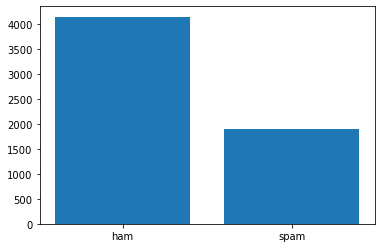

In [8]:
spam_amount = len(spam_paths)+len(spam_2_paths)
ham_amount = len(easy_ham_paths)+len(easy_ham_2_paths)+len(hard_ham_paths)
plt.bar(['ham', 'spam'], [ham_amount, spam_amount])

**2. Box plots of email lengths**

We created box plots for the email lengths in 2 classes and removed outliers since there are too many of them

In [127]:
def remove_null(datas,labels=[]):
    not_null_idx = [i for i,content in enumerate(datas) if content is not None ]
    if labels:
        return np.array(datas)[not_null_idx],np.array(labels)[not_null_idx]
    else:
        return np.array(datas)[not_null_idx]

In [55]:
def remove_object_type(datas, labels=[]):
    not_obj_idx = [i for i,content in enumerate(datas) if isinstance(content, list)]
    if labels:
        return np.array(datas)[not_obj_idxo],np.array(labels)[not_obj_idx]
    else:
        return np.array(datas)[not_obj_idx]

In [74]:
all_mails =[]
dirlist=[easy_ham_paths, easy_ham_2_paths, hard_ham_paths, 
         spam_paths, spam_2_paths]
for i, directory in enumerate(dirlist):
    all_mails.append([get_email_content(path) for path in directory])
    all_mails[i] =  [item for item in  all_mails[i]]
    assert (len(all_mails[i]) == len (dirlist[i])), \
    "The number of mails mismatched the number of email files in folder "+ (i+1) 

# Keep each email as a list of email content part(s)
all_ham = np.concatenate(all_mails[:3])
all_spam = np.concatenate(all_mails[3:])
print([len(all_ham), len(all_spam)], len(all_mails[2]))
print(all_ham.dtype)
print(len(all_ham[13]))

[4153, 1899] 251
object
2


In [15]:
# Examples of multipart emails:
print(all_ham[1179])
print(all_ham[1180])
for msg in all_ham[1181]:
    print(msg)

['In message <200210091843.OAA01268@hippolyta.crd.ge.com>, Kevin Kenny said:\n> \n> mcmasjc@tatanka.stortek.com said:\n> > 3)  You can learn to use procmail,\n> \nIt absolutely can be done from .forward.  I am in the same situation as you, \nand that is how I do it.\n-- \nJim McMaster\nmailto:mcmasjc@tatanka.stortek.com\n\n\n\n\n_______________________________________________\nExmh-users mailing list\nExmh-users@redhat.com\nhttps://listman.redhat.com/mailman/listinfo/exmh-users\n\n\n']
['\nOn Wed, 09 Oct 2002 14:43:32 EDT, Kevin Kenny writes:\n>> 3)  You can learn to use procmail,\n\n>Can this be done via .forward?\n\nmake your .forward contain only the following line:\n"|/usr/bin/procmail"\n (incl. the quotes, your procmail binary may be in another path)\n\ncheers,\n&rw\n-- \n-- For a list of points detailing how technology\n-- has failed to improve our lives, please press 3.                         \n\n\n', '-----BEGIN PGP SIGNATURE-----\nVersion: GnuPG v1.2.0 (GNU/Linux)\n\niD8DBQE9

{'whiskers': [<matplotlib.lines.Line2D at 0x19e21cb74e0>,
 'caps': [<matplotlib.lines.Line2D at 0x19e21cb7400>,
 'boxes': [<matplotlib.lines.Line2D at 0x19e22409dd8>,
 'medians': [<matplotlib.lines.Line2D at 0x19e22153d68>,
 'fliers': [],
 'means': []}

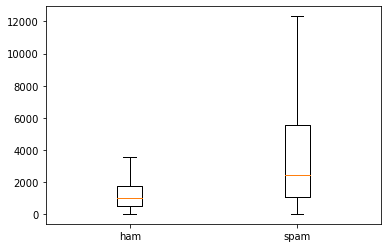

In [25]:
ham_mail_lengths = [np.vectorize(len)(flatten(email_parts)) for email_parts in all_ham]
spam_mail_lengths=[sum(np.vectorize(len)(email_parts)) for email_parts in all_spam]
#print(ham_mail_lengths, spam_mail_lengths)
plt.boxplot([ ham_mail_lengths, spam_mail_lengths], labels=['ham','spam'],showfliers=False)

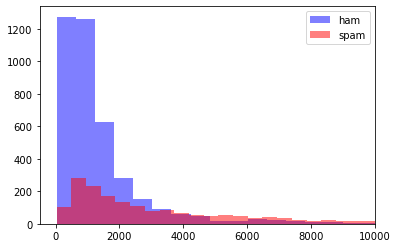

In [26]:
kwargs = dict(alpha=0.5, bins=500)
plt.hist(ham_mail_lengths,  **kwargs, color='b', label='ham')
plt.hist(spam_mail_lengths,  **kwargs, color='r', label='spam')
plt.xlim(-500,10000)
plt.legend()
#change to word count!

#### Split train-test data sets

Before we proceed further with pre-processing, it's important to first split the dataset into train and test sets by stratified samplings to maintain the right proportions of classes. This is essential since we have subcategories for non-spam mails: easy and hard.

We randomly split 70% of the dataset into the training set and use the remaining 30% as the testing set.

In [101]:
for mail_list in all_mails:
    print(len(mail_list))
    
# Prepare training set
ham_sample = np.array([train_test_split(email, train_size=0.7) for email in [np.concatenate(all_mails[:2]), all_mails[2]]])
ham_train = np.array([])
ham_test = np.array([])
for data in ham_sample:
    ham_train = np.concatenate((ham_train,data[0]),axis=0)
    ham_test = np.concatenate((ham_test,data[1]),axis=0)
print(ham_train.shape, ham_test.shape)
    
# Prepare testing set
spam_sample = np.array([train_test_split(email, train_size=0.7) for email in all_mails[3:]])
spam_train = np.array([])
spam_test = np.array([])
for data in spam_sample:
    spam_train = np.concatenate((spam_train,data[0]),axis=0)
    spam_test = np.concatenate((spam_test,data[1]),axis=0)
print(spam_train.shape, spam_test.shape)

# check if a sample contains a list of strings only:
# for i,mail in enumerate( ham_train):
#     for part in mail:
#         if not isinstance(part, str):
#             print(i) #should not print anything

2501
1401
251
501
1398
(2906,) (1247,)
(1328,) (571,)


D:\Anaconda3\envs\Dicom\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
D:\Anaconda3\envs\Dicom\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


#### Pre-processing

We used both corpus and metadata as features for our model. First, we created a clean-up pipeline create the corpus. Then, we used the occurrences of hyperlinks, html tags, and currency units as our metadata. We placed both types of features in a feature vector for training our models. (TODO: create a simple diagram to demonstrate the preprocessing plan)

##### Basic clean-up pipeline

1. Remove punctuations
2. Remove whitespaces
3. Remove special characters if any
4. Remove HTML tags if any
6. Remove numbers
5. Convert to lower case

For the simplicity of this project, we will also remove all hyperlinks and numbers, even though they can be useful features to boost classification accuracy. 

In [223]:
def clean_up_pipeline(text, idx):
    try:
        # remove hyperlinks
        text = re.sub(r"http\S+", "", text)
    
        # remove numbers
        text = re.sub(r'\d+', '', text)
            
        # remove punctuations
        text = text.translate(str.maketrans(dict.fromkeys(string.punctuation)))
        
        # remove whitespace
        text = text.strip()
        text = text.replace("\n", " ")
        text = text.replace("\t", " ")
    
        # remove HTML tags
        text = re.sub(re.compile('<.*?>'), ' htmltag ', text)
    
        # remove special characters
    
        #convert to lower case
        text = text.lower()
    except:
        #print(e)
        print(idx)
    return text

In [224]:
ham_train_clean =[] 
for mail in ham_train:
    content=[clean_up_pipeline(part, i) for i, part in enumerate(mail)]
    ham_train_clean.append(" ".join(content))

In [225]:
ham_test_clean =[] 
for mail in ham_test:
    content = [clean_up_pipeline(part, i) for i, part in enumerate(mail)]
    ham_test_clean.append(" ".join(content))

In [226]:
spam_train_clean =[] 
for mail in spam_train:
    content = [clean_up_pipeline(part, i) for i, part in enumerate(mail)]
    spam_train_clean.append(" ".join(content))

In [227]:
spam_test_clean =[] 
for mail in spam_test:
    content = [clean_up_pipeline(part, i) for i, part in enumerate(mail)]
    spam_test_clean.append(" ".join(content))

In [162]:
print(len(ham_train), len(ham_train_clean), len(ham_test), len(ham_test_clean),
     len(spam_train), len(spam_train_clean), len(spam_test), len(spam_test_clean),)

2906 2906 1247 1247 1328 1328 571 571


In [163]:
#check 1st email with multiparts
for i, mail in enumerate(ham_train):
    if len(mail) > 1:
        print(i, len(mail))
        for part in mail:
            print(part)
        print(ham_train_clean[i])
        break

1 2
> http://www.spamassassin.org
> Is anyone besides me having problems getting to the site?

What site is that one?  Isn't this site on sourceforge the official
home page?

  http://spamassassin.sourceforge.net/

Bob

-----BEGIN PGP SIGNATURE-----
Version: GnuPG v1.0.7 (GNU/Linux)

iD8DBQE9O3xf0pRcO8E2ULYRAnFFAJ4oIMwUH/vPP4yjvt7z8Gv/7CyFHgCfTmd6
nFFjYpkscA/GZoaiF8MBKCU=
=Udmt
-----END PGP SIGNATURE-----

is anyone besides me having problems getting to the site  what site is that one  isnt this site on sourceforge the official home page      bob begin pgp signature version gnupg v gnulinux  iddbqeoxfprcoeulyranffajoimwuhvppyjvtzgvcyfhgcftmd nffjypkscagzoaifmbkcu udmt end pgp signature


In [228]:
x_train = np.concatenate([ham_train_clean, spam_train_clean])
train_labels=[[0]*len(ham_train_clean), [1]*len(spam_train_clean)]
y_train = np.concatenate(train_labels)
x_test = np.concatenate([ham_test_clean, spam_test_clean])
test_labels=[[0]*len(ham_test_clean), [1]*len(spam_test_clean)]
y_test = np.concatenate(test_labels)

#Shuffle index once more
train_shuffle_index = np.random.permutation(np.arange(0,x_train.shape[0]))
test_shuffle_index = np.random.permutation(np.arange(0,x_test.shape[0]))

x_train = x_train[train_shuffle_index]
y_train = y_train[train_shuffle_index]
x_test = x_test[test_shuffle_index]
y_test = y_test[test_shuffle_index]
print(x_train[:2], y_train[:2], x_test[:2], y_test[:2])

['surely it would be faster to save you conf files install it on the box again copy back you confs and voila all you car about are the confs as the boite has no data right  thats what i would do but you sysadmins have to make life as difficult  complicated as possible   have you thought about mirroring the system drives might save you serious hassle down the line   only kidding but thats what i would do  cw   ok heres how to do it    while the disk is still installed in the i machine if thats broken beg borrow or steal remove the i versions of glibc and kernel and install the i versions  this will break one or two other packages since they have entries in etcldsoconf which belongs to glibc  these packages will need to be reinstalled  so   rpm e nodeps glibc   your etcldsoconf has been saved as etcldsoconfrpmsave   rpm ivh glibcvernoirpm  rpm e nodeps kernel  rpm ivh kernelvernoirpm  this installs the i versions of kernel and glibc  youll be able to boot in a non  machine now  however x

##### Natural language processing

Typically, this process includes the following steps:

1. Tokenization
2. Remove stop words
3. Stemming - convert the same word with different endings into the stem without caring about the lexis, e.g. fishing/fished/fisher -> fish; argue/ argued/ argues/ arguing/ argus -> argu
4. Lematization - theoretically, convert different forms of the same word into the dictionary form with the exact same meaning, e.g. goes -> go; am/is/are -> be, but different algorithms may not yield the same results.

Stemming and lematization are often not applied together given their overlapping results. In this exercise, lematization is more useful since we want to preserve the meaning of words. 

The WordNetLemmatizer that we used also required specifying part of speech (POS). Otherwise, it will assume we want nouns.

In [196]:
# examples of difference in lemmatization with and without a suitable POS
print(lemmatizer.lemmatize("better"))
print(lemmatizer.lemmatize("better", pos='v'))
print(lemmatizer.lemmatize("better", pos='a'))
      
print(lemmatizer.lemmatize("am"))
print(lemmatizer.lemmatize("am", pos='v'))

better
better
good
am
be


In [201]:
def clean_token_pipeline(text):
    # tokenization
    result = word_tokenize(text)
    
    # remove stop words
    result = [i for i in result if i not in ENGLISH_STOP_WORDS]
    
    # lemmatization
    result = [lemmatizer.lemmatize(word) for word in result]
    
    return result

In [229]:
x_train = [clean_token_pipeline(mail) for mail in x_train]
x_test = [clean_token_pipeline(mail) for mail in x_test]

In [230]:
x_train = [" ".join(o) for o in x_train]
x_test = [" ".join(o) for o in x_test]

In [231]:
x_train[0]

'surely faster save conf file install box copy confs voila car confs boite data right thats sysadmins make life difficult complicated possible thought mirroring drive save hassle line kidding thats cw ok here disk installed machine thats broken beg borrow steal remove version glibc kernel install version break package entry etcldsoconf belongs glibc package need reinstalled rpm e nodeps glibc etcldsoconf saved etcldsoconfrpmsave rpm ivh glibcvernoirpm rpm e nodeps kernel rpm ivh kernelvernoirpm installs version kernel glibc youll able boot non machine x broken kerberos noticed etcldsoconfrpmsave contain clue broken fix x kerberos need reinstall libs copying etcldsoconfrpmsave etcldsoconf doesnt work rpm ivh replacepkgs xfreelibsvernoirpm rpm ivh replacepkgs krblibsvernoirpm fix libs listed etcldsoconf qt mysql sane start behaving odd fashion related reinstalling libs package fix thanks guy snip wouldnt bog x thats thought useful server available user machine maybe staff maybew admin ca

**Visualize top 100 words**

In [207]:
from wordcloud import WordCloud, STOPWORDS

In [232]:
def plot_wordcloud(text, mask=None, max_words=100, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

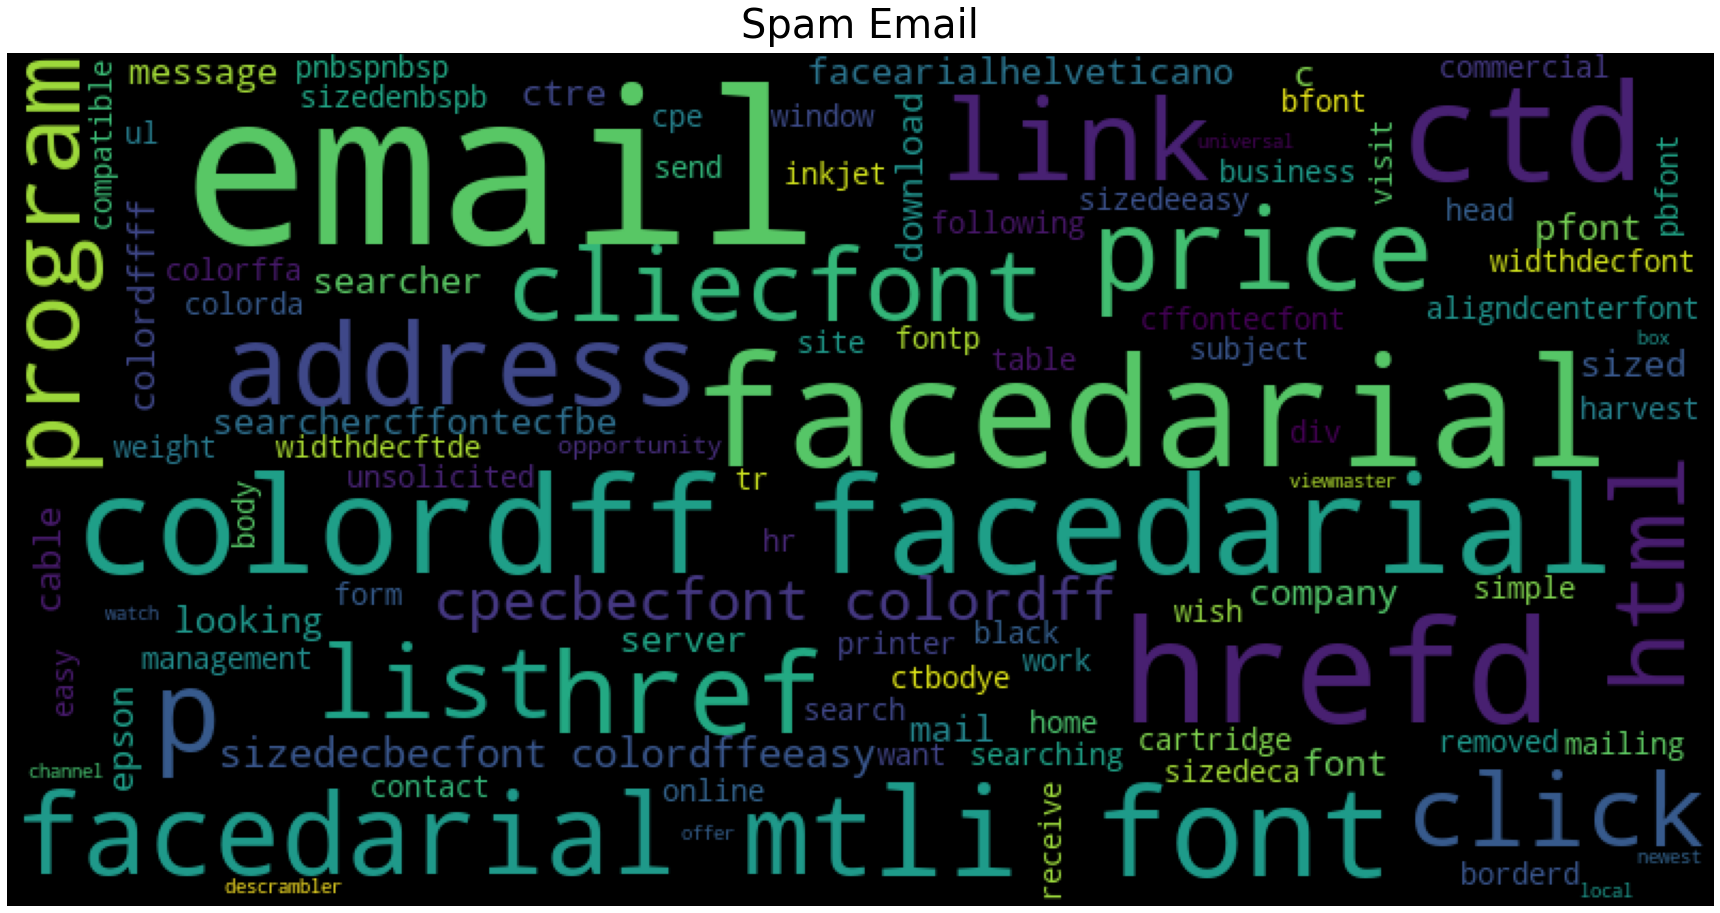

In [233]:
# Create wordcloud for the training set
spam_train_index = [i for i,o in enumerate(y_train) if o == 1]
# non_spam_train_index = [i for i,o in enumerate(y_train) if o == 0]
spam_email = np.array(x_train)[spam_train_index]
non_spam_email = np.array(x_train)[~np.array(spam_train_index)]

plot_wordcloud(spam_email,title = 'Spam Email')

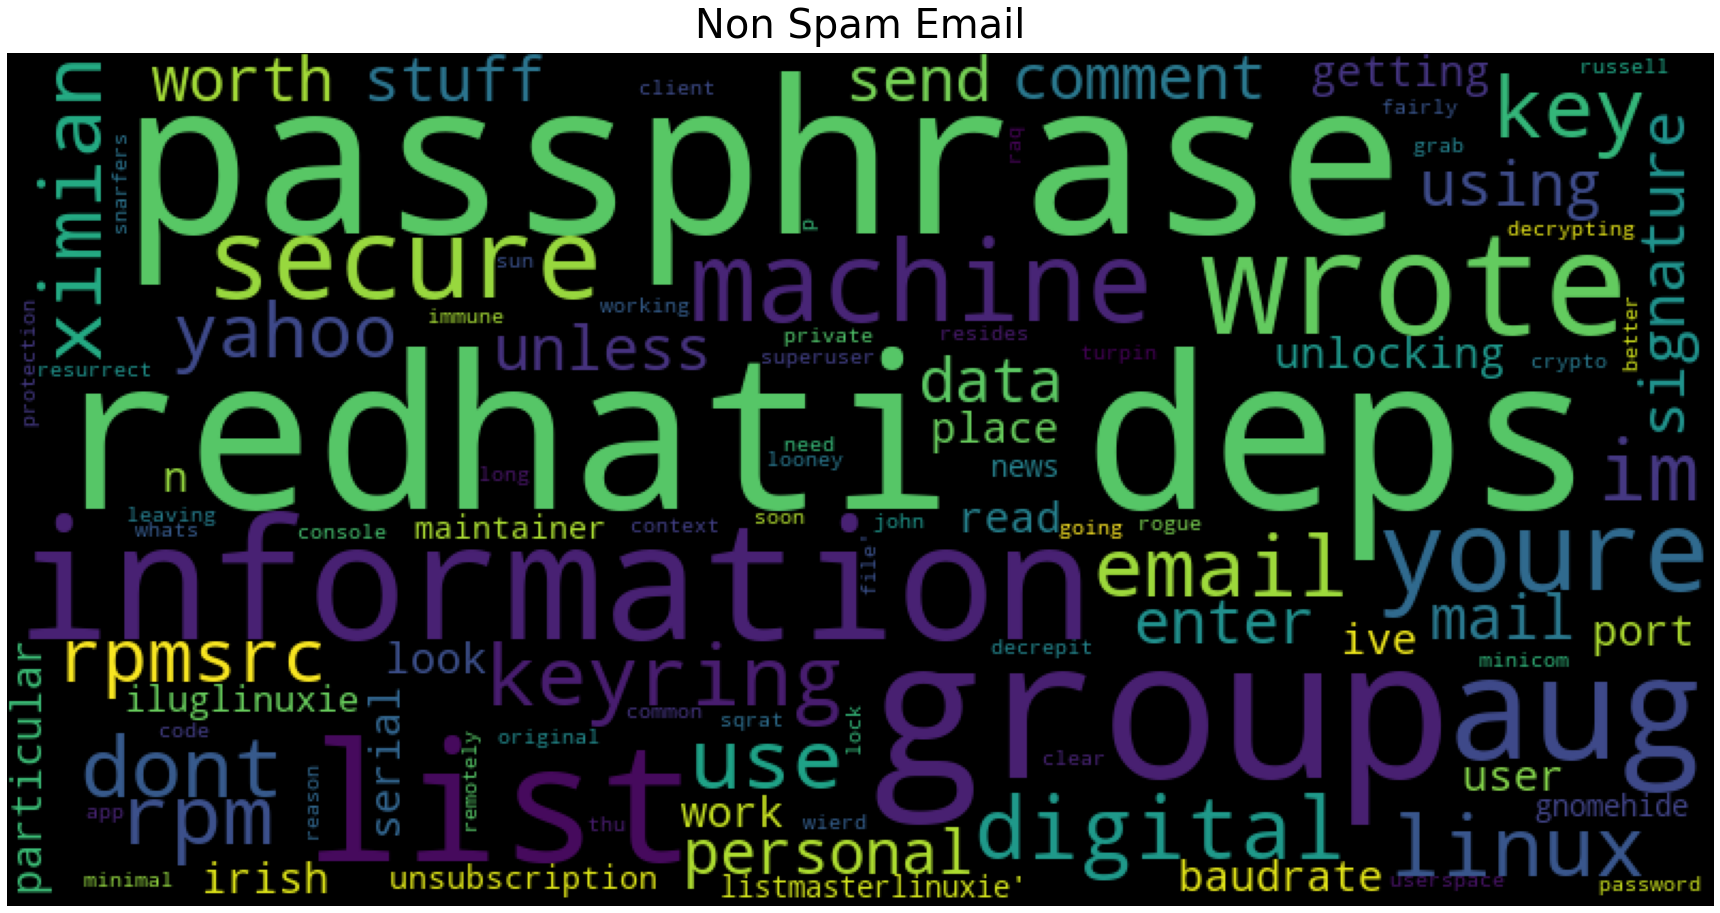

In [234]:
plot_wordcloud(non_spam_email,title="Non Spam Email")

**Visualize word frequency histogram**

TODO

## N-ram statistics

Use email body/ subject 

Histogram word frequency for each 

Build a good corpus ~100-200 words!!!! 

Statistics -> find the difference 

Word embedding: glove, reduce dimension

1 vector cho "http", 1 http-count, 1 currency representation (1-0)


## Feature Extraction

### TfidVectorizer

In [238]:
x_train = [o.split(" ") for o in x_train]
x_test = [o.split(" ") for o in x_test]

['surely',
 'faster',
 'save',
 'conf',
 'file',
 'install',
 'box',
 'copy',
 'confs',
 'voila',
 'car',
 'confs',
 'boite',
 'data',
 'right',
 'thats',
 'sysadmins',
 'make',
 'life',
 'difficult',
 'complicated',
 'possible',
 'thought',
 'mirroring',
 'drive',
 'save',
 'hassle',
 'line',
 'kidding',
 'thats',
 'cw',
 'ok',
 'here',
 'disk',
 'installed',
 'machine',
 'thats',
 'broken',
 'beg',
 'borrow',
 'steal',
 'remove',
 'version',
 'glibc',
 'kernel',
 'install',
 'version',
 'break',
 'package',
 'entry',
 'etcldsoconf',
 'belongs',
 'glibc',
 'package',
 'need',
 'reinstalled',
 'rpm',
 'e',
 'nodeps',
 'glibc',
 'etcldsoconf',
 'saved',
 'etcldsoconfrpmsave',
 'rpm',
 'ivh',
 'glibcvernoirpm',
 'rpm',
 'e',
 'nodeps',
 'kernel',
 'rpm',
 'ivh',
 'kernelvernoirpm',
 'installs',
 'version',
 'kernel',
 'glibc',
 'youll',
 'able',
 'boot',
 'non',
 'machine',
 'x',
 'broken',
 'kerberos',
 'noticed',
 'etcldsoconfrpmsave',
 'contain',
 'clue',
 'broken',
 'fix',
 'x',
 'ke

In [241]:
vectorizer = TfidfVectorizer()
raw_sentences = [' '.join(o) for o in x_train]
vectorizer.fit(raw_sentences)

TfidfVectorizer()

In [239]:
def convert_to_feature(raw_tokenize_data):
    raw_sentences = [' '.join(o) for o in raw_tokenize_data]
    return vectorizer.transform(raw_sentences)

In [242]:
x_train_features = convert_to_feature(x_train)
x_test_features = convert_to_feature(x_test)

In [244]:
vectorizer = CountVectorizer()
raw_sentences = [' '.join(o) for o in x_train]
vectorizer.fit(raw_sentences)
x_train_features = convert_to_feature(x_train)
x_test_features = convert_to_feature(x_test)

## Train models

1. Logistic regression
2. Naive Bayes
3. Decision trees
4. KNNs
5. MLPC
6. Random Forest

In [255]:
# Logistic regression
logreg_model = LogisticRegression()
logreg_model.fit(x_train_features.toarray(),y_train)
print(logreg_model.score(x_test_features.toarray(),y_test))

y_predict = logreg_model.predict(x_test_features.toarray())

precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
print("Logistic Regression Precision: {:.2f}%".format(100 * precision))
print("Logistic Regression Recall: {:.2f}%".format(100 * recall))
print("Logistic Regression F1 score: {:.2f}%".format(100*f1_score(y_test, y_predict)))

D:\Anaconda3\envs\Dicom\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9642464246424642
Logistic Regression Precision: 97.20%
Logistic Regression Recall: 91.24%
Logistic Regression F1 score: 94.13%


The recall or true positive rate is low can be explained by the imbalanced nature of the dataset, i.e. there are more non-spam than spam mails. 

In [268]:
models = [LogisticRegression,GaussianNB, 
          DecisionTreeClassifier, KNeighborsClassifier,
         MLPClassifier, RandomForestClassifier]
def fit_models(models=models):
    for i, m in enumerate(models):
        models[i]=m().fit(x_train_features.toarray(),y_train)
        yield models[i]

In [269]:
# Use a generator to train 1 model at a time without crashing the kernel
gen = fit_models()

In [290]:
%%time
next(gen)

Wall time: 1min 9s


RandomForestClassifier()

## Evaluate Models

**Elapsed time**

KNNs: 1min 19s

MLPC: 9min 56s

Random forest: 1min 9s

In [299]:
#output the metrics of all models at the same time
with parallel_backend('threading', n_jobs=-1):
    for i in [3]:
        start_time = time.time()
        score = models[i].score(x_test_features.toarray(),y_test)
        print(type(models[i]).__name__, " Accuracy: ",score)

        y_predict = models[i].predict(x_test_features.toarray())

        precision = precision_score(y_test, y_predict)
        print(type(models[i]).__name__+" Precision: {:.2f}%".format(100 * precision))

        recall = recall_score(y_test, y_predict)
        print(type(models[i]).__name__+" Recall: {:.2f}%".format(100 * recall))

        f1= f1_score(y_test, y_predict)
        print(type(models[i]).__name__+" F1 score: {:.2f}%".format(100*f1))
        print("----------- %s seconds -----------" % (time.time() - start_time))


KeyboardInterrupt: 

In [ ]:
from joblib import parallel_backend


**Confusion Matrix**

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
for i, m in enumerate(models):
    y_predict = m.predict(x_test_features.toarray())
    tn, fp, fn, tp=confusion_matrix(y_test,y_predict).ravel()

In [ ]:
import itertools
cnf_matrix = confusion_matrix(y_test,y_predict)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non Spam','Spam'], normalize=False,
                      title='Confusion matrix')

## Discussion

Some models took really long to train on our data, so we could simplify features further for them. Upon observing the most common tokens in spam mails, we noticed a lot of html-based tokens such as fonts, colors etc. Finding a method to simplify their representation could help us reduce the number of features required to train future models significantly.

We could try crawling some of our real emails to observe the performance of our models in more scenarios.

There are more methods of lemmatization and vectorization in NLP which we haven't had time to try out, so we could explore more NLP techinques in the future.  

## Reference

1. [Email Spam Detection Python repo by Sie Huai Gan](https://github.com/huai99/Email-Spam-Detection-Python)
2. [NLP Text Preprocessing: A practical guide and template](https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79)